# SPARK Week 6 - Assignment
Welcome to week 6! In this assignment, we will implement U-Net based on Pytorch to realize abnormality segmentation from Brain MRIs.

FYI, this assignment was self-implemented to match "McMedHacks Foundational Course" as much as possible, which thus is not toally same as the tutorial you watched.

### Mount on Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd gdrive/My Drive/SPARK Week 6 Assignments/

/content/gdrive/My Drive/Week 6 Assignments


### Imports

In [ ]:
import os
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
import glob
import cv2
from tqdm import tqdm
import torchvision
from skimage.io import imread,imsave
from collections import OrderedDict
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
! pip install torch-summary --quiet
! pip install MedPy --quiet
from skimage.transform import rescale,rotate
from torchvision.transforms import Compose
from medpy.filter.binary import largest_connected_component
from skimage.exposure import rescale_intensity
from skimage.transform import resize

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.8/151.8 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 17.9 MB/s eta 0:00:00


### Dataset and Dataloader

### Preprocessing helper functions

In [ ]:
# 1. cropping
def crop_sample(x):
  volume,mask = x
  volume[volume< np.max(volume)*0.1] =0
  #calculating z_proj
  z_proj = np.max(np.max(np.max(volume, axis=-1),axis=-1),axis=-1)
  z_nonzero = np.nonzero(z_proj)
  z_min = np.min(z_nonzero)
  z_max = np.max(z_nonzero)+1
  #calculating y_proj
  y_proj = np.max(np.max(np.max(volume, axis=0),axis=-1),axis=-1)
  y_nonzero = np.nonzero(y_proj)
  y_min = np.min(y_nonzero)
  y_max = np.max(y_nonzero)+1
  #calculating x_proj
  x_proj = np.max(np.max(np.max(volume, axis=0),axis=0),axis=-1)
  x_nonzero = np.nonzero(x_proj)
  x_min = np.min(x_nonzero)
  x_max = np.max(x_nonzero)+1
  volume_cropped = volume[z_min:z_max,y_min:y_max,x_min:x_max]
  mask_cropped = mask[z_min:z_max,y_min:y_max,x_min:x_max]

  return volume_cropped, mask_cropped

In [ ]:
#2. padding
def pad_sample(x):
  volume, mask=x
  a = volume.shape[1]
  b= volume.shape[2]
  if a == b:
    return volume,mask
  diff = (max(a,b) - min(a,b))/2.0
  if a>b:
    padding =((0,0),(0,0),(int(np.floor(diff)),int(np.ceil(diff))))
  else:
    padding=((0,0),(int(np.floor(diff)),int(np.ceil(diff))),(0,0))
  mask = np.pad(mask,padding, mode='constant', constant_values=0)
  padding = padding+((0,0),)
  volume = np.pad(volume, padding,mode='constant', constant_values=0)

  return volume, mask

In [ ]:
#3. Resizing
def resize_sample(x,size=256):
  volume,mask=x
  v_shape = volume.shape
  out_shape = (v_shape[0],size,size)
  mask = resize(
      mask, output_shape=out_shape,
      order=0,
      mode='constant',
      cval=0,
      anti_aliasing= False,
  )
  out_shape = out_shape + (v_shape[3],)
  volume = resize(
      volume,
      output_shape = out_shape,
      order=2,
      mode='constant',
      cval=0,
      anti_aliasing = False,
  )
  return volume, mask

In [ ]:
# 4. Normalizing
def normalize_volume(volume):
  p10 = np.percentile(volume,10)
  p99 = np.percentile(volume,99)
  volume = rescale_intensity(volume, in_range=(p10,p99))
  mean = np.mean(volume, axis=(0,1,2))
  standard_dev = np.std(volume, axis=(0,1,2))
  volume = (volume - mean)/standard_dev
  return volume

In [ ]:
#5. Logging
def gray2rgb(image):
  w,h = image.shape
  image+=np.abs(np.min(image))
  image_max = np.abs(np.max(image))
  if image_max>0:
    image/=image_max
  ret = np.empty((w,h,3), dtype=np.uint8)
  ret[:,:,2] = ret[:,:,1]= ret[:,:,0] = image*255
  return ret

def outline(image,mask,color):
  mask= np.round(mask)
  yy,xx = np.nonzero(mask)
  for y,x in zip(yy,xx):
    if 0.0 <np.mean(mask[max(0,y-1):y+2,max(0,x-1):x+2])<1.0:
      image[max(0,y):y+1, max(0,x):x+1]=color
  return image


def log_images(x,y_true,y_pred,channel=1):
  images=[]
  x_np = x[:,channel].cpu().numpy()
  y_true_np= y_true[:,channel].cpu().numpy()
  y_pred_np =y_pred[:,channel].cpu().numpy()
  for i in range(x_np.shape[0]):
    image = gray2rgb(np.squeeze(x_np[i]))
    image= outline(image,y_pred_np[i],colors=[255,0,0])
    image = outline(image,y_true_np[i],colors=[0,255,0])
    images.append(image)
  return images

### Data augmentation helper functions

In [ ]:
#1. Rotation class
class Rotate(object):
  def __init__(self,angle):
    self.angle = angle

  def __call__(self,sample):
    image,mask = sample
    angle = np.random.uniform(low=-self.angle, high= self.angle)
    image = rotate(image, angle,resize=False, preserve_range=True, mode="constant")
    mask= rotate(mask,angle,resize=False,order=0, preserve_range=True, mode="constant")
    return image, mask

In [ ]:
#2. Horizontal flip class
class HorizontalFlip(object):
  def __init__(self,flip_prob):
    self.flip_prob = flip_prob

  def __call__(self,sample):
    image,mask = sample

    if np.random.rand()>self.flip_prob:
      return image,mask

    image = np.fliplr(image).copy()
    mask = np.fliplr(mask).copy()

    return image,mask

In [ ]:
#applying transform using all the helper function
def transforms(angle=None, flip_prob=None):
  transforms_list = []
  if angle is not None:
    transforms_list.append(Rotate(angle))
  if flip_prob is not None:
    transforms_list.append(HorizontalFlip(flip_prob))

  return Compose(transforms_list)

### Train and validation split

<font color='green'>ToDo:</font>
Write comments for the lines where you think it is hard to understand for "BrainMRIDataset"

In [ ]:
class BrainMRIDataset(torch.utils.data.Dataset):
  in_channels = 3
  out_channels = 1

  def __init__(self,images_dir, transform=None, image_size=256, subset="train",random_sampling=True, validation_cases=10,seed=42):
    assert subset in ["all","train","val"]
    #reading images
    image_volumes = {}
    masks = {}
    print("reading {} images and masks".format(subset))
    for (dir_path,dirnames,filenames) in os.walk(os.path.join(images_dir, subset)): #Walking through subfolders
      image_slices = []
      mask_slices = []
      for filename in sorted(filter(lambda f: "mask.tif" in f,filenames),
          key=lambda x: int(x.split(".")[-2].split("_")[4])):
        file_path = os.path.join(dir_path,filename)

        mask_temp = imread(file_path,as_gray=True)
        mask_temp = np.array(mask_temp > 0, np.float_)

        if np.sum(mask_temp) > 0:
          mask_slices.append(mask_temp)
          image_slices.append(imread(file_path.replace('_mask.tif', '.tif'))) #Renaming and appending the file in one step

      if len(image_slices)>0:
        patient_id = dir_path.split("/")[-1]
        image_volumes[patient_id] = np.array(image_slices[1:-1])
        masks[patient_id] = np.array(mask_slices[1:-1])
        #Not 100% sure what is going on up there. Maybe 70%?

    self.patients = sorted(image_volumes)

    print("preprocessing {} volumes..".format(subset))

    self.image_volumes = [(image_volumes[k], masks[k]) for k in self.patients]

    #cropping
    print("cropping {} volumes".format(subset))
    self.image_volumes = [crop_sample(v) for v in self.image_volumes]

    #padding
    print("padding {} volumes".format(subset))
    self.image_volumes = [pad_sample(v) for v in self.image_volumes]

    #resizing
    print("Resizing {} volumes".format(subset))
    self.image_volumes = [resize_sample(v,size=image_size) for v in self.image_volumes]

    #normalising
    print("Normalising {} volumes".format(subset))
    self.image_volumes = [(normalize_volume(v),m) for v,m in self.image_volumes]

    # probab for sampling slices based on masks
    self.slice_weights = [m.sum(axis=-1).sum(axis=-1) for v,m in self.image_volumes]

    self.slice_weights =[
        (s +(s.sum()*0.1/len(s)))/(s.sum()*1.1) for s in self.slice_weights
    ]

    # A Lot of list comprehension going on.
    #adding channel dimension to mask

    self.image_volumes = [(v,m[...,np.newaxis]) for (v,m) in self.image_volumes]

    print("Dataset creation done for {}".format(subset))

    #create global index for patient and slice

    num_slices = [v.shape[0] for v,m in self.image_volumes]
    self.patient_slice_index = list(
        zip(
            sum([[i]* num_slices[i] for i in range(len(num_slices))],[]),
            sum([list(range(x)) for x in num_slices],[])
        )
    )
    # Even more comprehension
    self.random_sampling = random_sampling
    self.transform = transform


  def __len__(self):
    return len(self.patient_slice_index)

  def __getitem__(self,idx):
    patient = self.patient_slice_index[idx][0]
    slice_n = self.patient_slice_index[idx][1]

    if self.random_sampling:
      patient = np.random.randint(len(self.image_volumes))
      slice_n = np.random.choice(
          range(self.image_volumes[patient][0].shape[0]), p = self.slice_weights[patient])

    v,m = self.image_volumes[patient]
    image = v[slice_n]
    mask = m[slice_n]

    if self.transform is not None:
      image,mask = self.transform((image,mask))

    #fixing dimensions to match pytorch since transform is done via CV,
    image = image.transpose(2,0,1)
    mask = mask.transpose(2,0,1)

    image_tensor = torch.from_numpy(image.astype(np.float32))
    mask_tensor = torch.from_numpy(mask.astype(np.float32))

    return image_tensor,mask_tensor


In [ ]:
#creating data loader
def datasets():
  angle=10
  image_size=128
  images= "kaggle_3m"

  train_dataset = BrainMRIDataset(
      images_dir= images,
      subset="train",
      image_size=image_size,
      transform = transforms(angle=angle,flip_prob=0.5))

  val_dataset = BrainMRIDataset(
      images_dir= images,
      subset="val",
      image_size=image_size,
      random_sampling = False
  )

  print("training data size", train_dataset.__len__())
  print("validation data size", val_dataset.__len__())
  return train_dataset, val_dataset

<font color='green'>ToDo:</font>
In the above data loading, we just selected the images slices with lesions, namely, (np.sum(mask_temp) > 0). What are the advantage and disadvantage about this operation.

An advantage is to ensure the model only learns relevant features needed for segmentation, which can be efficient.

A disadvantage is that the model may overfit, and not generalise properly due to a lack of negative features.

### Loss and Evaluation Matrices (<font color='green'>ToDo</font>)

In [ ]:
### ToDo ###
# fil-up the Dice loss and score
# Dice loss = 2 * interesection/total
class DiceLoss(nn.Module):
  def __init__(self):
    super().__init__()
    self.smooth = 1.0

  def forward(self,y_pred,y_true):
    assert y_pred.size() == y_true.size()
    y_pred = y_pred[:,0].contiguous().view(-1)
    y_true = y_true[:,0].contiguous().view(-1)

    intersection = (y_pred * y_true).sum()
    dice_score = (2.0 * intersection + self.smooth) / (
        y_pred.sum() + y_true.sum() + self.smooth)

    return 1.0 - dice_score

#general helper function
def dice_score(y_pred, y_true):
  if np.any(y_pred):
    y_pred = np.round(y_pred).astype(int)
    y_true = np.round(y_true).astype(int)
    y_pred = largest_connected_component(y_pred)

    ## ToDo
    intersection = (y_pred * y_true).sum()
    smooth = 1.0
    dice = (2.0 * intersection + smooth) / (y_pred.sum() + y_true.sum() + smooth)

  return dice

def dice_score_per_vol(val_pred,val_true, patient_slice_index):
  dsc_list = []
  num_slices = np.bincount([p[0] for p in patient_slice_index])
  index=0
  for p in range(len(num_slices)):
    y_pred = np.array(val_pred[index:index+num_slices[p]])
    y_true = np.array(val_true[index:index+num_slices[p]])
    dsc_list.append(dice_score(y_pred,y_true))
    index += num_slices[p]

  return dsc_list

### Network (<font color='green'>ToDo</font>)

In [ ]:
class UNET(nn.Module):
    def _init_(self, input_channels=3, output_channels=1, num_features=32):
        super()._init_()
        features = num_features

        # architecture of Unet3D deriving conv blocks
        # Stage 1
        self.encoder1 = UNET.conv_block(input_channels, features, name="enc1_")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Stage 2
        self.encoder2 = UNET.conv_block(features, features*2, name="enc2_")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Stage 3
        self.encoder3 = UNET.conv_block(features*2, features*4, name="enc3_")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Stage 4
        self.encoder4 = UNET.conv_block(features*4, features*8, name="enc4_")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Stage 5 - Bottom part of U, Bottleneck
        self.bottleneck = UNET.conv_block(features*8, features*16, name="bottleneck_")

        # Stage 6 - Going up in the U in the decoder layer
        self.upconv4 = nn.ConvTranspose2d(features*16, features*8, kernel_size=2, stride=2)
        self.decoder4 = UNET.conv_block(features*16, features*8, name='dec4_')

        # Stage 7 - Going up in the U in the decoder layer
        self.upconv3 = nn.ConvTranspose2d(features*8, features*4, kernel_size=2, stride=2)
        self.decoder3 = UNET.conv_block(features*8, features*4, name='dec3_')

        # Stage 8 - Going up in the U in the decoder layer
        self.upconv2 = nn.ConvTranspose2d(features*4, features*2, kernel_size=2, stride=2)
        self.decoder2 = UNET.conv_block(features*4, features*2, name='dec2_')

        # Stage 9 - Going up in the U in the decoder layer
        self.upconv1 = nn.ConvTranspose2d(features*2, features, kernel_size=2, stride=2)
        self.decoder1 = UNET.conv_block(features*2, features, name='dec1_')

        # mask generation conv layer
        self.final_conv = nn.Conv2d(features, output_channels, kernel_size=1)

    def forward(self, x):
        # encoder pass
        enc1 = self.encoder1(x)
        x = self.pool1(enc1)
        enc2 = self.encoder2(x)
        x = self.pool2(enc2)
        enc3 = self.encoder3(x)
        x = self.pool3(enc3)
        enc4 = self.encoder4(x)
        x = self.pool4(enc4)
        x = self.bottleneck(x)

        # decoder pass
        x = self.upconv4(x)
        x = torch.cat([x, enc4], dim=1)
        x = self.decoder4(x)
        x = self.upconv3(x)
        x = torch.cat([x, enc3], dim=1)
        x = self.decoder3(x)
        x = self.upconv2(x)
        x = torch.cat([x, enc2], dim=1)
        x = self.decoder2(x)
        x = self.upconv1(x)
        x = torch.cat([x, enc1], dim=1)
        x = self.decoder1(x)
        x = self.final_conv(x)
        return torch.sigmoid(x)

    @staticmethod
    def conv_block(in_channels, num_features, name):
        return nn.Sequential(
            OrderedDict([
                (name + "conv1", nn.Conv2d(in_channels, num_features, kernel_size=3, padding=1)),
                (name + "bn1", nn.BatchNorm2d(num_features)),
                (name + "relu1", nn.ReLU(inplace=True)),
                (name + "conv2", nn.Conv2d(num_features, num_features, kernel_size=3, padding=1)),
                (name + "bn2", nn.BatchNorm2d(num_features)),
                (name + "relu2", nn.ReLU(inplace=True)),
            ])
        )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
network = UNET.to(device)

### Training

In [ ]:
dice_loss = DiceLoss()
best_val_dice_score=0.0

num_epochs=25
batch_size = 4

optimizer = optim.SGD(network.parameters(), lr=0.001)
train_loss = []
val_loss = []
step = 0

# initialising the data loaders
train_data, val_data = datasets()

train_loader = DataLoader(
    train_data,batch_size=4, shuffle=True,
    drop_last = True, num_workers=4
)

val_loader = DataLoader(
    val_data, batch_size=4, shuffle = True,
    drop_last=True, num_workers =4)

loaders = {'train':train_loader,'val':val_loader}

In [ ]:
# training loop

for epoch in tqdm(range(num_epochs),total=num_epochs):
  for phase in ["train", "val"]:
    if phase == "train":
      network.train()
    else:
      network.eval()

    val_pred = []
    val_true = []

    for i, data in enumerate(loaders[phase]):
      if phase =="train":
        step+=1

      x, y_true = data
      x,y_true = x.to(device), y_true.to(device)

      optimizer.zero_grad()

      with torch.set_grad_enabled(phase=="train"):
        y_pred = network(x)

        loss = dice_loss(y_pred,y_true)

        if phase == "val":
          val_loss.append(loss.item())
          y_pred_np = y_pred.detach().cpu().numpy()
          val_pred.extend(
              [y_pred_np[s] for s in range(y_pred_np.shape[0])]
          )

          y_true_np= y_true.detach().cpu().numpy()
          val_true.extend(
              [y_true_np[s] for s in range(y_true_np.shape[0])]
          )

        if phase == "train":
          train_loss.append(loss.item())
          loss.backward()
          optimizer.step()

      if phase =="train" and (step+1)%1500 ==0:
        print("step- {}, train_loss-{}".format(step,sum(train_loss)/len(train_loss)))
        train_loss = []

  if phase =="val":
    print("step - {}, val_loss-{}".format(step,sum(val_loss)/len(val_loss)))
    mean_dice_score = np.mean(
        dice_score_per_vol(val_pred, val_true,
                           val_loader.dataset.patient_slice_index)

    )
    print("step- {}, mean dice score- {}".format(step,mean_dice_score))

    if mean_dice_score > best_val_dice_score:
        best_val_dice_score = mean_dice_score
        torch.save(network.state_dict(),"unet_brain_mri.pth")
    val_loss = []

print("Best val mean dice score -{}".format(best_val_dice_score))

  0%|          | 0/25 [00:00<?, ?it/s]

step - 276, val_loss-0.8647192964951197


  4%|▍         | 1/25 [00:16<06:26, 16.09s/it]

step- 276, mean dice score- 0.14656584402804199
step - 552, val_loss-0.8570237904787064
step- 552, mean dice score- 0.2214763692138743


  8%|▊         | 2/25 [00:31<06:01, 15.73s/it]

step - 828, val_loss-0.8495049476623535
step- 828, mean dice score- 0.24784232315581675


 12%|█▏        | 3/25 [00:51<06:27, 17.61s/it]

step - 1104, val_loss-0.8439888954162598
step- 1104, mean dice score- 0.3059677706684894


 16%|█▌        | 4/25 [01:10<06:19, 18.07s/it]

step - 1380, val_loss-0.8290849228700002
step- 1380, mean dice score- 0.40257276446091594


 20%|██        | 5/25 [01:26<05:47, 17.37s/it]

step- 1499, train_loss-0.8501455144853572


 24%|██▍       | 6/25 [01:39<05:02, 15.93s/it]

step - 1656, val_loss-0.8188187976678213
step- 1656, mean dice score- 0.30983312696664034
step - 1932, val_loss-0.8092520932356516
step- 1932, mean dice score- 0.5143905273925957


 28%|██▊       | 7/25 [01:51<04:25, 14.76s/it]

step - 2208, val_loss-0.800496886173884
step- 2208, mean dice score- 0.5487000224200236


 32%|███▏      | 8/25 [02:04<04:00, 14.18s/it]

step - 2484, val_loss-0.7916246155897776
step- 2484, mean dice score- 0.5515607125829696


 36%|███▌      | 9/25 [02:16<03:35, 13.46s/it]

step - 2760, val_loss-0.7746042360862097
step- 2760, mean dice score- 0.5604034704735021


 40%|████      | 10/25 [02:29<03:18, 13.22s/it]

step- 2999, train_loss-0.7953084884484609


 44%|████▍     | 11/25 [02:41<02:59, 12.85s/it]

step - 3036, val_loss-0.764484648903211
step- 3036, mean dice score- 0.5619097336343761


 48%|████▊     | 12/25 [02:53<02:44, 12.67s/it]

step - 3312, val_loss-0.7349792222181956
step- 3312, mean dice score- 0.6647543971224243


 52%|█████▏    | 13/25 [03:05<02:29, 12.47s/it]

step - 3588, val_loss-0.7183194359143575
step- 3588, mean dice score- 0.611192311153414


 56%|█████▌    | 14/25 [03:17<02:15, 12.35s/it]

step - 3864, val_loss-0.6910296728213629
step- 3864, mean dice score- 0.6145124283096555


 60%|██████    | 15/25 [03:29<02:02, 12.22s/it]

step - 4140, val_loss-0.6727059384187063
step- 4140, mean dice score- 0.5467416545583681


 64%|██████▍   | 16/25 [03:40<01:47, 11.98s/it]

step - 4416, val_loss-0.6327741394440333
step- 4416, mean dice score- 0.5289788323405078
step- 4499, train_loss-0.7109630585908889


 68%|██████▊   | 17/25 [03:53<01:36, 12.00s/it]

step - 4692, val_loss-0.5985259910424551
step- 4692, mean dice score- 0.6706734522728044


 72%|███████▏  | 18/25 [04:05<01:24, 12.10s/it]

step - 4968, val_loss-0.5712544520696005
step- 4968, mean dice score- 0.6389134055411625


 76%|███████▌  | 19/25 [04:17<01:12, 12.04s/it]

step - 5244, val_loss-0.5344578971465429
step- 5244, mean dice score- 0.6152446940409153


 80%|████████  | 20/25 [04:29<01:00, 12.02s/it]

step - 5520, val_loss-0.5036546091238657
step- 5520, mean dice score- 0.5896283741244723


 84%|████████▍ | 21/25 [04:41<00:47, 11.98s/it]

step - 5796, val_loss-0.44807396332422894
step- 5796, mean dice score- 0.6329767440035048
step- 5999, train_loss-0.5462917091846466


 88%|████████▊ | 22/25 [04:52<00:35, 11.84s/it]

step - 6072, val_loss-0.4410252074400584
step- 6072, mean dice score- 0.6142707184693731


 92%|█████████▏| 23/25 [05:04<00:23, 11.77s/it]

step - 6348, val_loss-0.40554775794347125
step- 6348, mean dice score- 0.5980782805824882


 96%|█████████▌| 24/25 [05:16<00:11, 11.83s/it]

step - 6624, val_loss-0.3900434970855713
step- 6624, mean dice score- 0.5750454337034274


100%|██████████| 25/25 [05:28<00:00, 13.15s/it]

step - 6900, val_loss-0.35635924835999805
step- 6900, mean dice score- 0.6604847178766611
Best val mean dice score -0.6706734522728044


### Evaluation

In [ ]:
phase = "val"
with torch.set_grad_enabled(False):
  #loading the dataset
  #state_dict = torch.load("unet_brain_mri.pt", map_location=device)
  #unet.load_state_dict(state_dict)
  network.eval()
  network.to(device)

  input_list=[]
  pred_list = []
  true_list = []

  for i, date in tqdm(enumerate(loaders[phase])):
    x,y_true = data
    x,y_true = x.to(device),y_true.to(device)
    y_pred = network(x)

    y_pred_np = y_pred.detach().cpu().numpy()
    pred_list.extend([y_pred_np[s] for s in range(y_pred_np.shape[0])])

    y_true_np = y_true.detach().cpu().numpy()
    true_list.extend(
              [y_true_np[s] for s in range(y_true_np.shape[0])]
          )

    x_np = x.detach().cpu().numpy()
    input_list.extend(
              [x_np[s] for s in range(x_np.shape[0])]
          )


def postprocess_per_volume(input_list, pred_list,true_list,patient_slice_index,patients):
  volumes={}
  num_slices = np.bincount([p[0] for p in patient_slice_index])
  index = 0
  for p in range(len(num_slices)):
    volume_in = np.array(input_list[index:index+num_slices[p]])
    volume_pred = np.round(
        np.array(pred_list[index:index+num_slices[p]])
    ).astype(int)
    for pp in range(volume_pred.shape[0]):
      volume_pred[pp, :, ...] = largest_connected_component(volume_pred[pp, :, ...])
    volume_true = np.array(true_list[index:index+num_slices[p]])

    volumes[patients[p]] = (volume_in, volume_pred, volume_true)
    index+= num_slices[p]

  return volumes

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
12it [00:00, 24.57it/s]


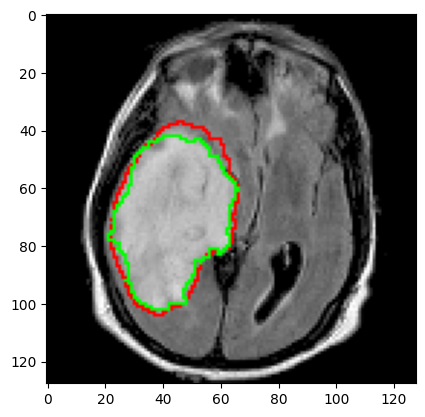

In [ ]:
volumes = postprocess_per_volume(
    input_list,pred_list,true_list, loaders[phase].dataset.patient_slice_index,
    loaders[phase].dataset.patients,
)

for p in volumes:
  x = volumes[p][0]
  y_pred = volumes[p][1]
  y_true = volumes[p][2]
  for s in range(x.shape[0]):
    image = gray2rgb(x[s,1])
    image = outline(image,y_pred[s,0], color=[255,0,0])
    image = outline(image,y_true[s,0], color=[0,255,0])
    plt.imshow(image)
    plt.show()
    break

### Discussion  (<font color='green'>ToDo</font>)
1. What actions can we do to further improve the segmentation performance based on the above implementation?

2. What potential issues or challenges will be caused by the the above actions?